In [1]:
# Importação das bibliotecas

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os

## Carregamento e limpeza dos dados

In [2]:
# Carregamento da base de dados

url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Verificando as tabelas disponíveis na página para o carregamento

tables = pd.read_html(url, decimal=",", thousands=".")

# Função para identificar a tabela correta

tbl = next(
    i for i, t in enumerate(tables)
    if pd.to_datetime(t.iloc[:,0], errors="coerce", dayfirst=True).notna().sum() > 10
)

print(f"Tabela correta encontrada no índice {tbl}")

Tabela correta encontrada no índice 2


In [3]:
# Criação do DataFrame e ajuste dos dados

df = tables[tbl].iloc[:, :2]
df.columns = ["date", "value"]

df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")

df = df.dropna().sort_values("date").reset_index(drop=True)
df.head()


,date,value
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
# Verificação do tamanho do DataFrame

df.shape

(11538, 2)

## Análise Exploratória dos Dados

In [5]:
# Estatísticas do DataFrame

df["value"].describe()

count    11538.000000
mean        53.688537
std         32.915849
min          9.100000
25%         20.850000
50%         50.245000
75%         76.610000
max        143.950000
Name: value, dtype: float64

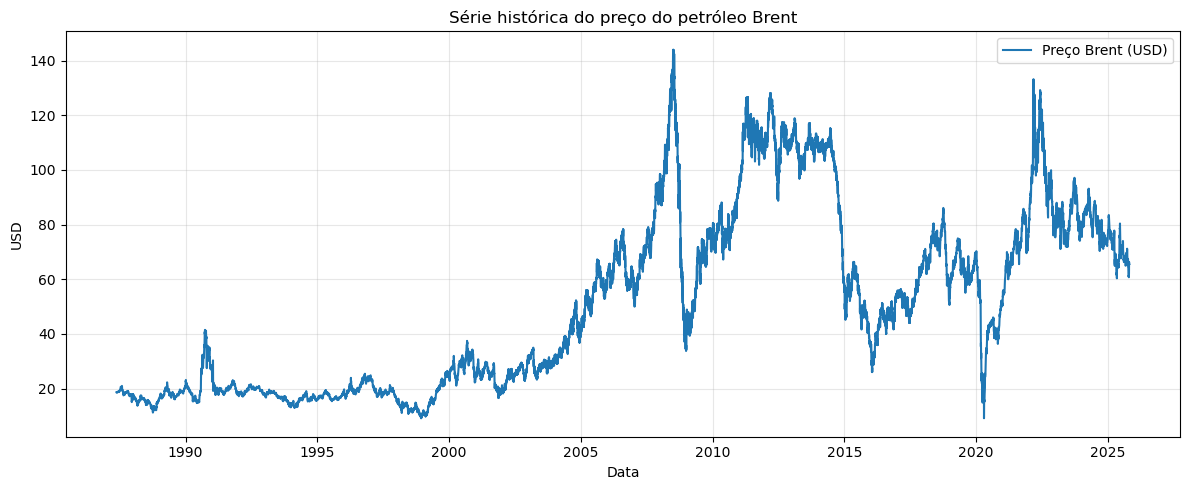

In [6]:
#  Visualização da série histórica

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["value"], label="Preço Brent (USD)")
plt.title("Série histórica do preço do petróleo Brent")
plt.xlabel("Data")
plt.ylabel("USD")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

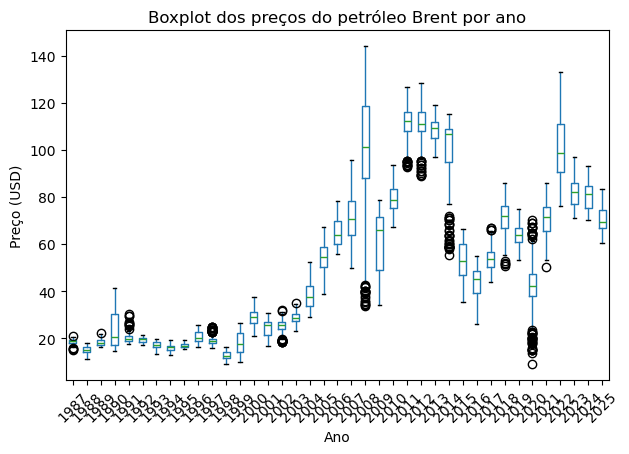

In [7]:
# Boxplot dos preços por ano

df["year"] = df["date"].dt.year

plt.figure(figsize=(20,6))
box = df.boxplot(column="value", by="year", grid=False)
plt.title("Boxplot dos preços do petróleo Brent por ano")
plt.suptitle("")
plt.xlabel("Ano")
plt.ylabel("Preço (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

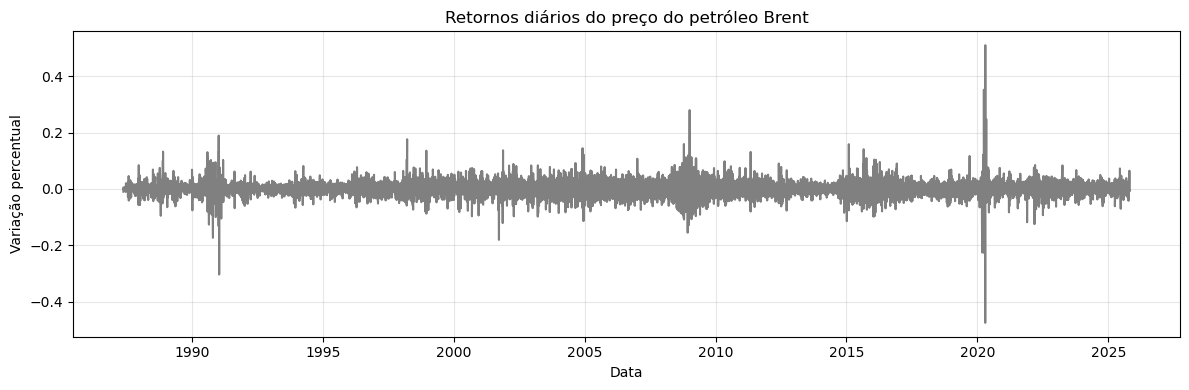

In [8]:
# Retornos diários (variação percentual)

df["return"] = df["value"].pct_change()

# Plote dos resultados

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["return"], color="gray")
plt.title("Retornos diários do preço do petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Variação percentual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# Preparação da série temporal

ts = df.set_index("date")["value"].asfreq("D")
ts = ts.ffill()

<Figure size 1200x800 with 0 Axes>

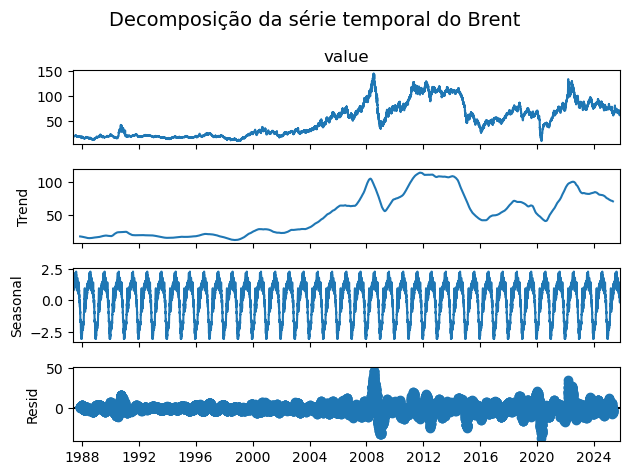

In [10]:
# Decomposição da série temporal

from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposição da série temporal

decomp = seasonal_decompose(ts, model="additive", period=365)

# Visualização dos componentes

plt.figure(figsize=(12,8))
decomp.plot()
plt.suptitle("Decomposição da série temporal do Brent", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Teste de estacionariedade ADF

from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)

# Exibe os resultados
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critérios de significância:")
for key, value in result[4].items():
    print(f"  {key}: {value:.4f}")

ADF Statistic: -2.2662537809733423
p-value: 0.1830828307842412
Critérios de significância:
  1%: -3.4308
  5%: -2.8617
  10%: -2.5669


In [12]:
# Aplicação da diferenciação para tornar a série estacionária

ts_diff = ts.diff().dropna()

# Verifica novamente a estacionariedade

result_diff = adfuller(ts_diff)
print("ADF Statistic (diferenciada):", result_diff[0])
print("p-value:", result_diff[1])

ADF Statistic (diferenciada): -16.30839203517397
p-value: 3.214308595052837e-29


## Modelagem utilizando o SARIMA

In [13]:
# Importação das bibliotecas

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
# Seleciona os últimos 3 anos da série (considerando os cenários geopolíticos recentes e o pós pandemia)

ts_treino = ts[-3*365:]

# Parâmetros simplificados e sazonalidade mensal

order = (1, 1, 0)
seasonal_order = (0, 1, 1, 30)

# Treina o modelo SARIMA com otimizações

modelo_sarima = sm.tsa.SARIMAX(
    ts_treino,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True,
    low_memory=True
)

resultado = modelo_sarima.fit(method='powell', maxiter=50, disp=False)
print(resultado.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                 1095
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 30)   Log Likelihood               -1828.338
Date:                              Thu, 30 Oct 2025   AIC                           3662.675
Time:                                      21:26:51   BIC                           3677.585
Sample:                                  10-29-2022   HQIC                          3668.325
                                       - 10-27-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0600      0.024      2.496      0.013       0.013       0.107
ma.S.L30      -0.98

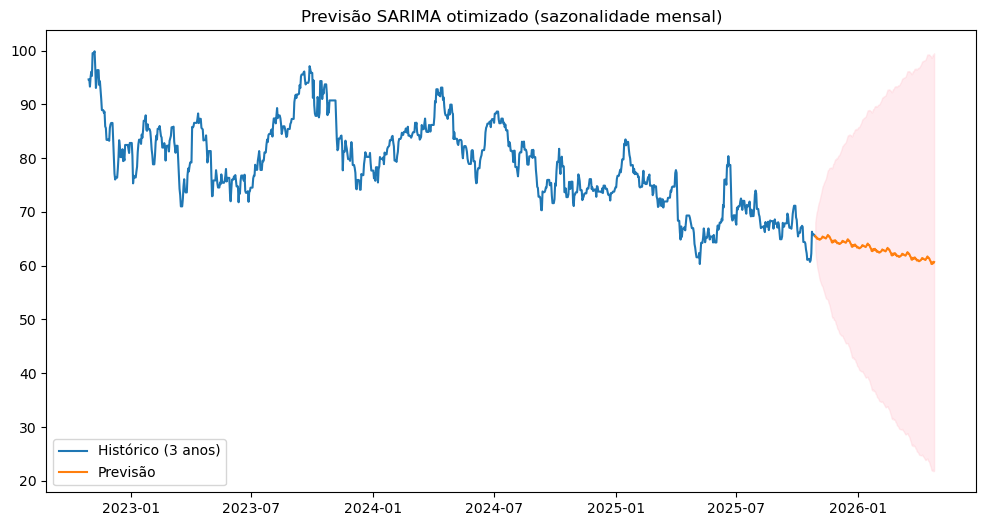

In [15]:
# Previsão para os próximos 180 dias

forecast = resultado.get_forecast(steps=180)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(ts_treino, label='Histórico (3 anos)')
plt.plot(predicted_mean, label='Previsão')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Previsão SARIMA otimizado (sazonalidade mensal)')
plt.show()


In [16]:
# Métricas de avaliação do modelo

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define o horizonte de comparação (últimos 180 dias)

ts_real = ts[-180:]
ts_previsto = resultado.get_prediction(start=ts_real.index[0], end=ts_real.index[-1]).predicted_mean

# Calculo das métricas

mae = mean_absolute_error(ts_real, ts_previsto)
rmse = np.sqrt(mean_squared_error(ts_real, ts_previsto))
mape = np.mean(np.abs((ts_real - ts_previsto) / ts_real)) * 100

# Resultados
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE:  0.84
RMSE: 1.24
MAPE: 1.23%


## Modelagem utilizando o Random Forest

In [17]:
# Importação das bibliotecas

from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

In [ ]:
# Estabecimento da seed

RANDOM_SEED = 42

In [19]:
# Prepara os dados com lags e variáveis de data

df_rf = ts[-3*365:].reset_index()
df_rf.columns = ['date', 'value']
df_rf['lag1'] = df_rf['value'].shift(1)
df_rf['lag2'] = df_rf['value'].shift(2)
df_rf['lag3'] = df_rf['value'].shift(3)
df_rf['dayofweek'] = df_rf['date'].dt.dayofweek
df_rf['month'] = df_rf['date'].dt.month
df_rf['day'] = df_rf['date'].dt.day

# Remove valores nulos

df_rf.dropna(inplace=True)

# Divide em treino e teste (últimos 180 dias como teste)

train = df_rf[:-180]
test = df_rf[-180:]

# Features e target

X_train = train[['lag1', 'lag2', 'lag3', 'dayofweek', 'month', 'day']]
y_train = train['value']
X_test = test[['lag1', 'lag2', 'lag3', 'dayofweek', 'month', 'day']]
y_test = test['value']

# Treina o modelo

rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

# Previsão

y_pred = rf.predict(X_test)

# Métricas

mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mape_rf = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE RF:  {mae_rf:.2f}")
print(f"RMSE RF: {rmse_rf:.2f}")
print(f"MAPE RF: {mape_rf:.2f}%")


MAE RF:  1.45
RMSE RF: 1.94
MAPE RF: 2.18%


In [20]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

# Prepara os dados com lags e variáveis de data

df_rf = ts[-3*365:].reset_index()
df_rf.columns = ['date', 'value']
df_rf['lag1'] = df_rf['value'].shift(1)
df_rf['lag2'] = df_rf['value'].shift(2)
df_rf['lag3'] = df_rf['value'].shift(3)
df_rf['dayofweek'] = df_rf['date'].dt.dayofweek
df_rf['month'] = df_rf['date'].dt.month
df_rf['day'] = df_rf['date'].dt.day
df_rf.dropna(inplace=True)

# Treina o modelo

X = df_rf[['lag1', 'lag2', 'lag3', 'dayofweek', 'month', 'day']]
y = df_rf['value']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Previsão recursiva para os próximos 180 dias

ultimos = df_rf.iloc[-1].copy()
previsoes = []
datas = []

for _ in range(180):
    nova_data = ultimos['date'] + timedelta(days=1)
    nova_linha = {
        'lag1': ultimos['value'],
        'lag2': ultimos['lag1'],
        'lag3': ultimos['lag2'],
        'dayofweek': nova_data.dayofweek,
        'month': nova_data.month,
        'day': nova_data.day
    }
    pred = rf.predict(pd.DataFrame([nova_linha]))[0]
    previsoes.append(pred)
    datas.append(nova_data)

    # Atualiza os lags para o próximo dia

    ultimos['date'] = nova_data
    ultimos['lag2'] = ultimos['lag1']
    ultimos['lag1'] = ultimos['value']
    ultimos['value'] = pred

# Série prevista

df_rf_forecast = pd.DataFrame({'date': datas, 'rf_pred': previsoes}).set_index('date')

## Comparação dos Modelos

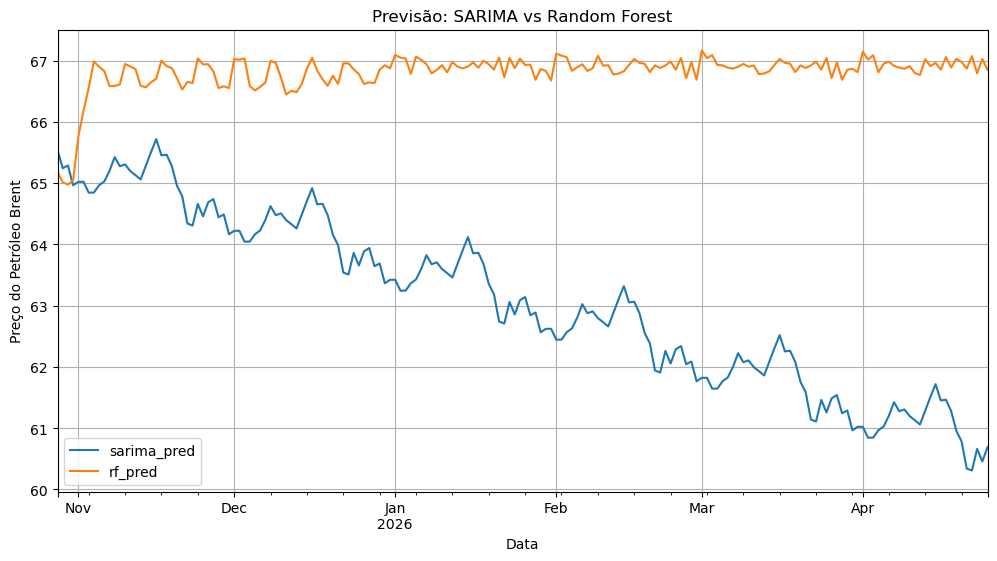

In [21]:
# Previsão SARIMA

sarima_forecast = resultado.get_forecast(steps=180)
sarima_pred = sarima_forecast.predicted_mean
sarima_pred.name = 'sarima_pred'

# Junta as previsões

df_comparativo = pd.concat([sarima_pred, df_rf_forecast['rf_pred']], axis=1)

# Gráfico comparativo

df_comparativo.plot(figsize=(12, 6), title='Previsão: SARIMA vs Random Forest')
plt.ylabel('Preço do Petróleo Brent')
plt.xlabel('Data')
plt.grid(True)
plt.show()

In [22]:
# Simulação dos valores reais como continuação da série

valores_reais = ts[-180:].values

# Alinhamento das datas

sarima_vals = sarima_pred.values[:180]
rf_vals = df_rf_forecast['rf_pred'].values[:180]

# Cálculo das métricas

def calc_metricas(y_true, y_pred, modelo):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{modelo} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

calc_metricas(valores_reais, sarima_vals, "SARIMA")
calc_metricas(valores_reais, rf_vals, "Random Forest")


SARIMA → MAE: 5.24 | RMSE: 6.16 | MAPE: 7.51%
Random Forest → MAE: 2.78 | RMSE: 3.84 | MAPE: 4.00%


In [23]:
# Salvando o modelo do Random Forest treinado

import joblib

joblib.dump(rf, "modelo_rf.pkl")

['modelo_rf.pkl']

In [24]:
# Exportando os dados para CSV

ts.to_csv("dados_petroleo.csv")